In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from tqdm import tqdm
from torchvision import datasets

plt.rcParams["figure.figsize"] = (8, 6)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Optimization methods

## Gradient descent

### On single-variable functions

#### Question 1

In [3]:
def gradient_descent(f,x0,eta,epsilon, max_iter = 1000):
    x = sp.symbols("x")
    df = sp.lambdify(x,sp.diff(f(x),x)) # The derivative of f (works if f if not too complicated)
    i = 1
    while np.abs(df(x0)) > epsilon and i < max_iter:
        x0 -= eta * df(x0)
        i += 1
    if i == max_iter:
        print("Max iter limit reached")
    return x0

#### Question 2

x**2 - x + 1

0.5049690791479365


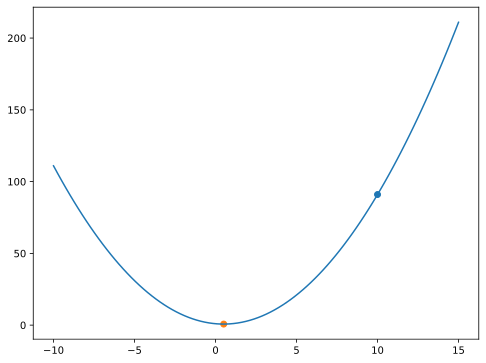

In [4]:
g = lambda x: x**2 - x + 1
x0 = 10
eta = .01
epsilon = .01
result = gradient_descent(g, x0, eta, epsilon)

x = np.linspace(-10, 15, 100)
plt.plot(x, g(x))
plt.scatter(x0, g(x0))
plt.scatter(result, g(result))
display(g(sp.symbols('x')))
print(result)

#### Question 3

0.01*x**4 + 0.02*x**3 - 0.12*x**2 - 0.02*x + 0.06

0.5049690791479365


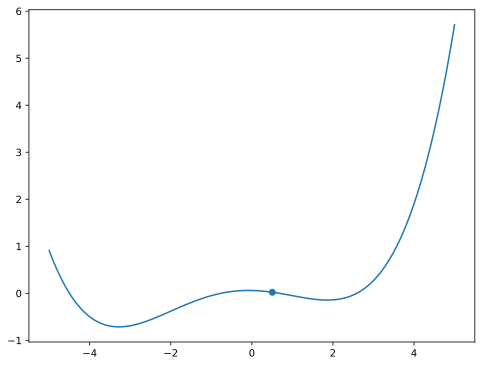

In [5]:
f = lambda x: 0.01*(x**4+2*x**3-12*x**2-2*x+6)
x0 = 10
eta = .01
epsilon = .01
result = gradient_descent(g, x0, eta, epsilon)

x = np.linspace(-5, 5, 100)
plt.plot(x, f(x))
# plt.scatter(x0, f(x0))
plt.scatter(result, f(result))
display(f(sp.symbols('x')))
print(result)

#### Question 4

x

0.454650368


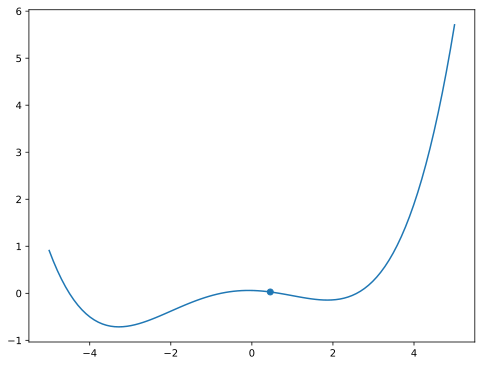

In [6]:
f = lambda x: 0.01*(x**4+2*x**3-12*x**2-2*x+6)
x0 = -4
eta = .2
epsilon = .1
result = gradient_descent(g, x0, eta, epsilon)

x = np.linspace(-5, 5, 100)
plt.plot(x, f(x))
# plt.scatter(x0, f(x0))
plt.scatter(result, f(result))
display((sp.symbols('x')))
print(result)

#### Question 5

$x_0$ will be alternating between $8$ and $-8$

In [7]:
f = lambda x: x**2
x0 = -4
eta = 1
epsilon = 1
result = gradient_descent(f, x0, eta, epsilon)

Max iter limit reached


## Learning by gradient descent

### FashionMNIST

With the gradient descent algorithm, we will try to learn to recognize clothes. For this, we will use the dataset FashionMNIST. It consists in 28x28 images of clothes labeled in 10 categories. Here is an extract of this dataset:

In [8]:
training_data = datasets.FashionMNIST(".",download=True,train=True)
test_data = datasets.FashionMNIST(".",download=True,train=False)

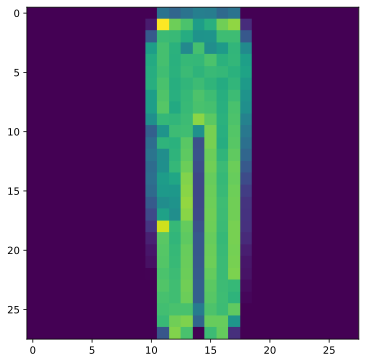

In [9]:
plt.imshow(training_data[1000][0])

In [10]:
test_data = [(np.ndarray.flatten(np.array(img))/255, cat) for img,cat in test_data]
training_data = [(np.ndarray.flatten(np.array(img))/255, cat) for img,cat in training_data]
np.random.shuffle(training_data) # shuffle the training set which was ordered

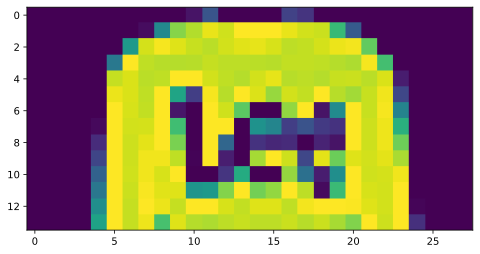

In [11]:
img = test_data[1][0].copy().reshape(28,28)
plt.imshow(img[:14,:])

### Gradient descent

#### Question 6

In [15]:
def propagate(w, b, training_data):
    n = len(training_data)
    x = np.vstack([ img for img, _  in training_data])
    y = np.hstack([ label for _, label in training_data])
    tmp = y - np.dot(x, w) - b
    cost = np.mean(tmp**2)
    gradw = -2.0/n * np.dot(tmp, x)
    gradb = -2.0 * np.mean(tmp)
    return (cost, gradw, gradb)

In [16]:
w = np.random.randn(784)
b = np.random.randn()
cost, gradw, gradb = propagate(w, b, training_data)
print(cost.shape, gradw.shape, gradb.shape)

() (784,) ()


#### Question 7

In [17]:
def optimize_gd(w, b, training_data, rate=5e-3, maxiter=1000, info=10):
    costs = []
    pbar = tqdm(range(maxiter))
    for i in pbar:
        cost, gradw, gradb = propagate(w, b, training_data)
        w -= rate * gradw
        b -= rate * gradb
        costs.append(cost)
        pbar.set_postfix(cost=cost)
    return w, b, costs

In [22]:
w = np.random.randn(784)
b = np.random.randn()
w_gd, b_gd, costs_gd = optimize_gd(w, b, training_data[:1000], maxiter=3000)

100%|██████████| 3000/3000 [00:13<00:00, 222.03it/s, cost=3.09]


#### Test of the model

In [23]:
def test_params(w, b, test_data, n_categories=10):
    x = np.vstack([ img for img, _  in test_data])
    y = np.hstack([ label for _, label in test_data])
    pred = np.clip(np.dot(x, w) + b, 0, n_categories - 1)
    pred = np.round(pred, decimals=0).astype(int)
    acc = np.mean(pred == y)
    return acc

Accuracy: 0.2306


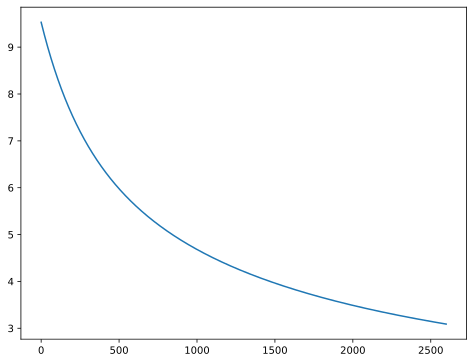

In [28]:
plt.plot(np.arange(len(costs_gd[400:])), costs_gd[400:])
acc = test_params(w_gd, b_gd, test_data)
print("Accuracy:", acc)

#### Stochastic gradient descent

##### Mini-batch

#### Question 8

In [29]:
def propagate_vect(w, b, x, y):
    n = x.shape[0]
    tmp = y - np.dot(x, w) - b 
    cost = np.mean(tmp**2)
    gradw = -2.0 * np.dot(tmp, x) / n
    gradb = -2.0 * np.mean(tmp)
    return (cost, gradw, gradb)

def optimize_sgdm(w,b,training_data, batch_size=100, rate=5e-5, maxepoch=40, info=1):
    x = np.vstack([ img for img, _  in training_data])
    y = np.hstack([ label for _, label in training_data])
    n = x.shape[0]
    costs = []
    pbar = tqdm(range(maxepoch * n // batch_size))
    for i in pbar:
        batch = np.random.choice(n, size=batch_size, replace=False)
        cost, gradw, gradb = propagate_vect(w, b, x[batch], y[batch])
        w -= rate * gradw
        b -= rate * gradb
        costs.append(cost)
        pbar.set_postfix(cost=cost)
    return w, b, costs

In [32]:
w = np.random.randn(784)
b = np.random.randn()
w_sgdm, b_sgdm, costs_sgdm = optimize_sgdm(w, b, training_data, maxepoch = 60)

100%|██████████| 36000/36000 [01:30<00:00, 399.42it/s, cost=12]  


Accuracy: 0.182


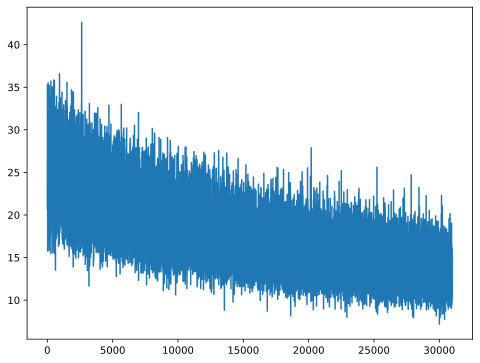

In [34]:
plt.plot(np.arange(len(costs_sgdm[5000:])), costs_sgdm[5000:])
acc = test_params(w_sgdm, b_sgdm, test_data)
print("Accuracy:", acc)

### Gradient descent with momentum

#### Question 11

In [35]:
def optimize_sgd_moment(w,b,training_data, batch_size = 100, rate=1e-3,mu=0.95, maxepoch=40, info=1):
    x = np.vstack([ img for img, _  in training_data])
    y = np.hstack([ label for _, label in training_data])
    n = x.shape[0]
    v_w = np.zeros_like(w)
    v_b = np.zeros_like(b)
    costs = []
    pbar = tqdm(range(maxepoch * n // batch_size))
    for i in pbar:
        batch = np.random.choice(n, size=batch_size, replace=False)
        cost, gradw, gradb = propagate_vect(w, b, x[batch], y[batch])
        v_w = mu * v_w - rate * gradw
        v_b = mu * v_b - rate * gradb
        w += v_w
        b += v_b
        costs.append(cost)
        pbar.set_postfix(cost=cost)
    return w, b, costs

In [36]:
w = np.random.randn(784)
b = np.random.randn()
w_sgd_moment, b_sgd_moment, costs_sgd_moment = optimize_sgd_moment(w, b, training_data)

100%|██████████| 24000/24000 [00:57<00:00, 415.72it/s, cost=2.38] 


Accuracy: 0.379


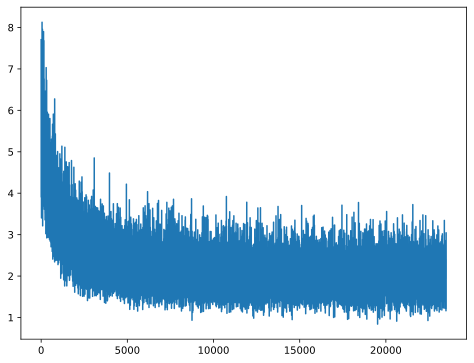

In [37]:
plt.plot(np.arange(len(costs_sgd_moment[500:])), costs_sgd_moment[500:])
acc = test_params(w_sgd_moment, b_sgd_moment, test_data)
print("Accuracy:", acc)

#### Question 12

In [38]:
def optimize_sgd_adam(w,b,training_data,rate=1e-3,beta1=0.9,beta2=0.999,epsilon=1e-8,batch_size=100, maxepoch=40,info=1):
    x = np.vstack([ img for img, _  in training_data])
    y = np.hstack([ label for _, label in training_data])
    n = x.shape[0]
    m_w = np.zeros_like(w)
    v_w = np.zeros_like(w)
    m_b = np.zeros_like(b)
    v_b = np.zeros_like(b)
    costs = []
    pbar = tqdm(range(maxepoch * n // batch_size))
    for i in pbar:
        batch = np.random.choice(n, size=batch_size, replace=False)
        cost, gradw, gradb = propagate_vect(w, b, x[batch], y[batch])
        m_w = beta1 * m_w + (1 - beta1) * gradw
        v_w = beta2 * v_w + (1 - beta2) * gradw * gradw
        m_b = beta1 * m_b + (1 - beta1) * gradb
        v_b = beta2 * v_b + (1 - beta2) * gradb * gradb
        m_w_hat = m_w / (1 - beta1**(i+1))
        v_w_hat = v_w / (1 - beta2**(i+1))
        m_b_hat = m_b / (1 - beta1**(i+1))
        v_b_hat = v_b / (1 - beta2**(i+1))
        w -= rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        b -= rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)
        costs.append(cost)
        pbar.set_postfix(cost=cost)
    return w, b, costs
    

In [40]:
w = np.random.randn(784)
b = np.random.randn()
w, b, costs = optimize_sgd_adam(w, b, training_data, maxepoch=40)

100%|██████████| 24000/24000 [01:06<00:00, 359.36it/s, cost=2.39]


Accuracy: 0.3608


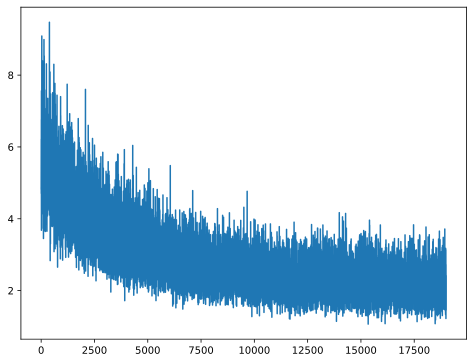

In [41]:
plt.plot(np.arange(len(costs[5000:])), costs[5000:])
acc = test_params(w, b, test_data)
print("Accuracy:", acc)

(0.0, 120.0)

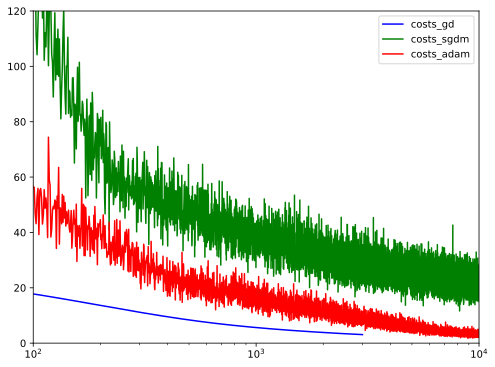

In [53]:
def graph(**kwargs):
	colors = "bgrcmykw:"
	fig, ax = plt.subplots()

	for name,color in zip(kwargs,colors):
		ax.semilogx(kwargs[name],color,label=name)
	ax.legend()
	
# example of use
graph(costs_gd=costs_gd, costs_sgdm=costs_sgdm, costs_adam=costs)
plt.gca().set_xlim(100,10000)
plt.gca().set_ylim(0,120)
# The label of [1,2,3] is "toto1"